<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **Exercícios**

## 1\. Ingestão

Replique as atividades da aula 1.

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

A primeira etapa da avaliação consiste em provisionar corretamente o bucket de armazenamento de dados crus no S3 da AWS. Aqui, você deve acessar o console do Amazon S3, criar um novo bucket e nomeá-lo de modo claro e consistente, incluindo o sufixo -raw para indicar que ali estarão armazenados somente os arquivos de entrada, antes de qualquer tipo de processamento. Esse cuidado de nomenclatura facilita a identificação dos dados ao longo de todo o pipeline.

Em seguida, é fundamental que o bucket criado realmente apresente o sufixo -raw no seu identificador. Caso você tenha criado o bucket sem esse sufixo, será preciso recriá-lo ou renomeá-lo (criando um novo com o nome correto) para manter o padrão adotado no projeto. Uma convenção clara previne confusões e possibilita um versionamento organizado dos artefatos de dados.



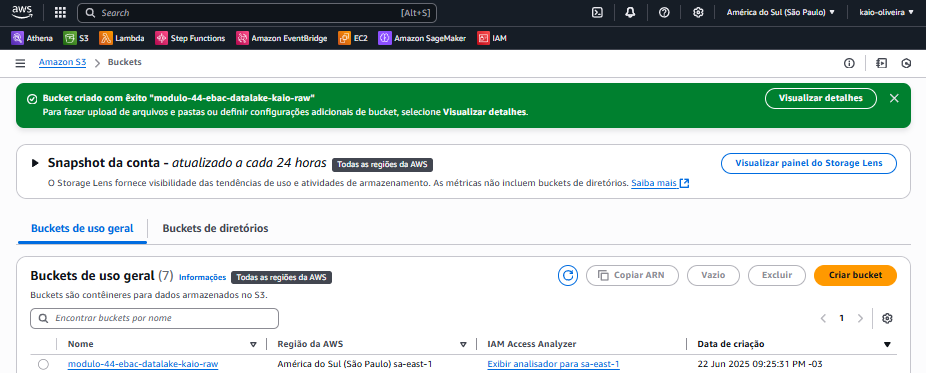

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

A terceira avaliação envolve a criação de uma função serverless no AWS Lambda, responsável por receber as mensagens — por exemplo, de um bot de chat — e gravá-las em formato JSON dentro do bucket -raw. Para isso, você deve definir o código da função (em Python, Node.js ou outra linguagem suportada), configurar a role do Lambda com permissão de escrita no S3 e testar localmente ou com eventos de teste para garantir que os objetos JSON sejam persistidos corretamente.

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

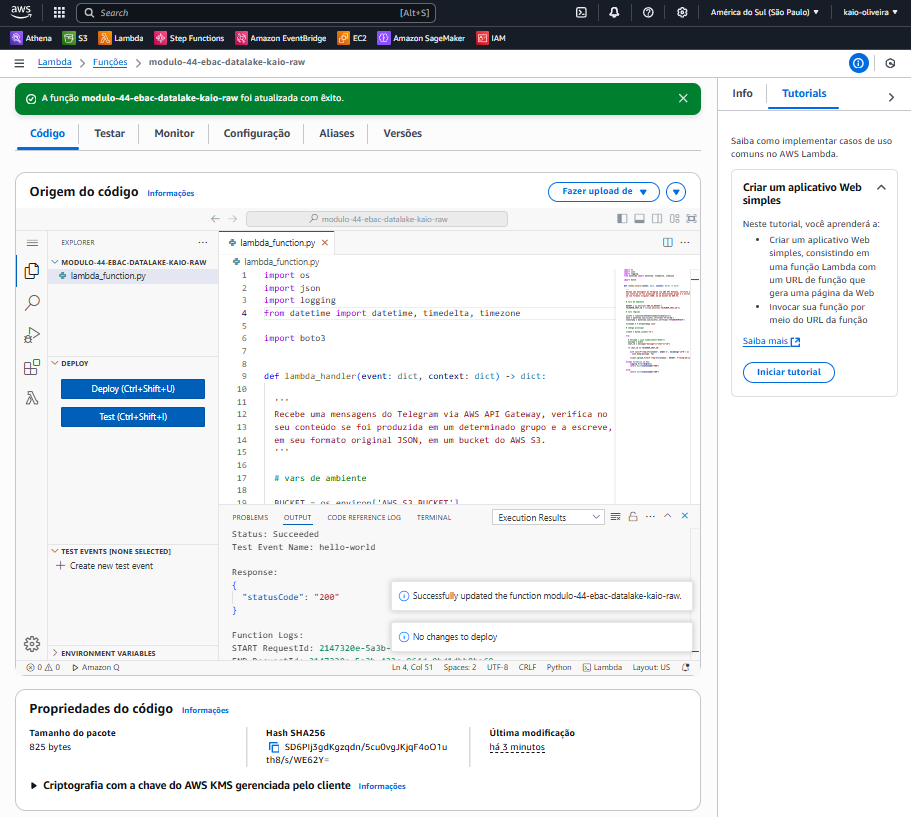

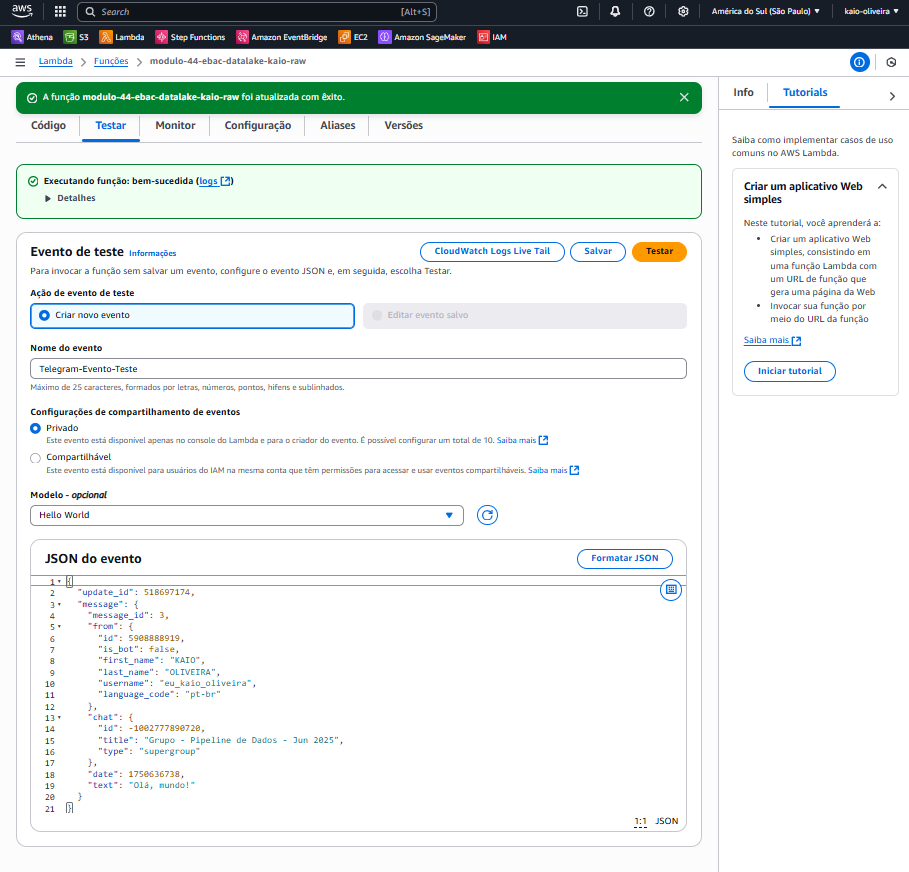

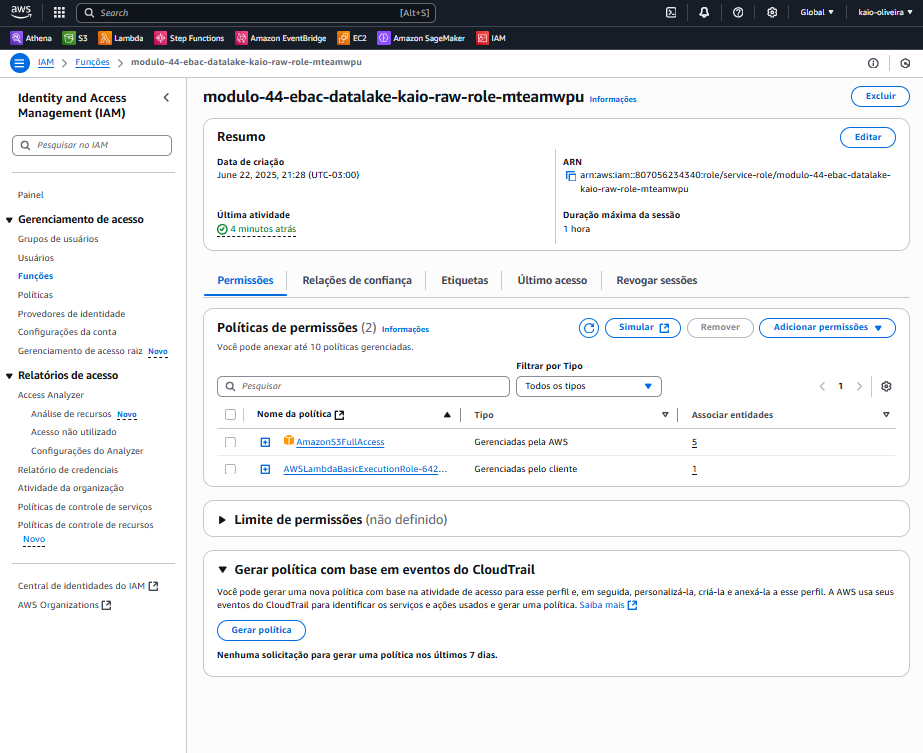

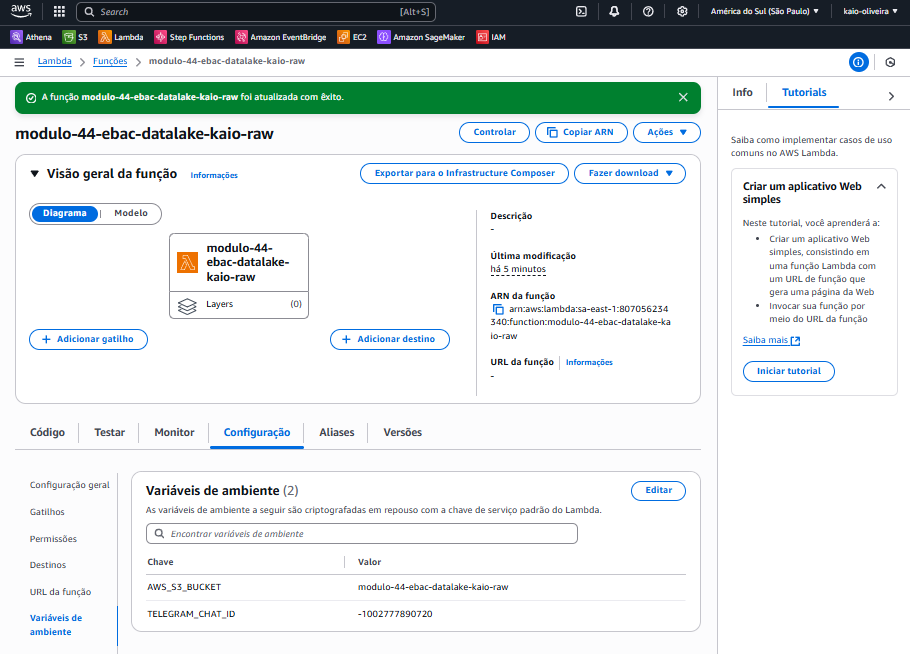

1.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`, conforme apresentado na aula.

Depois, você precisa expor essa função Lambda por meio de uma API HTTP criada no AWS API Gateway. Ao definir a rota (por exemplo, um endpoint POST) e integrá-la à sua função, o Gateway encaminhará automaticamente as requisições recebidas ao código Lambda. Copiar a URL gerada pelo API Gateway e testá-la com ferramentas como curl ou Postman assegura que o fluxo de dados esteja configurado conforme apresentado em aula.

> **Nota**: não disponibilize o endereço da API gerada.

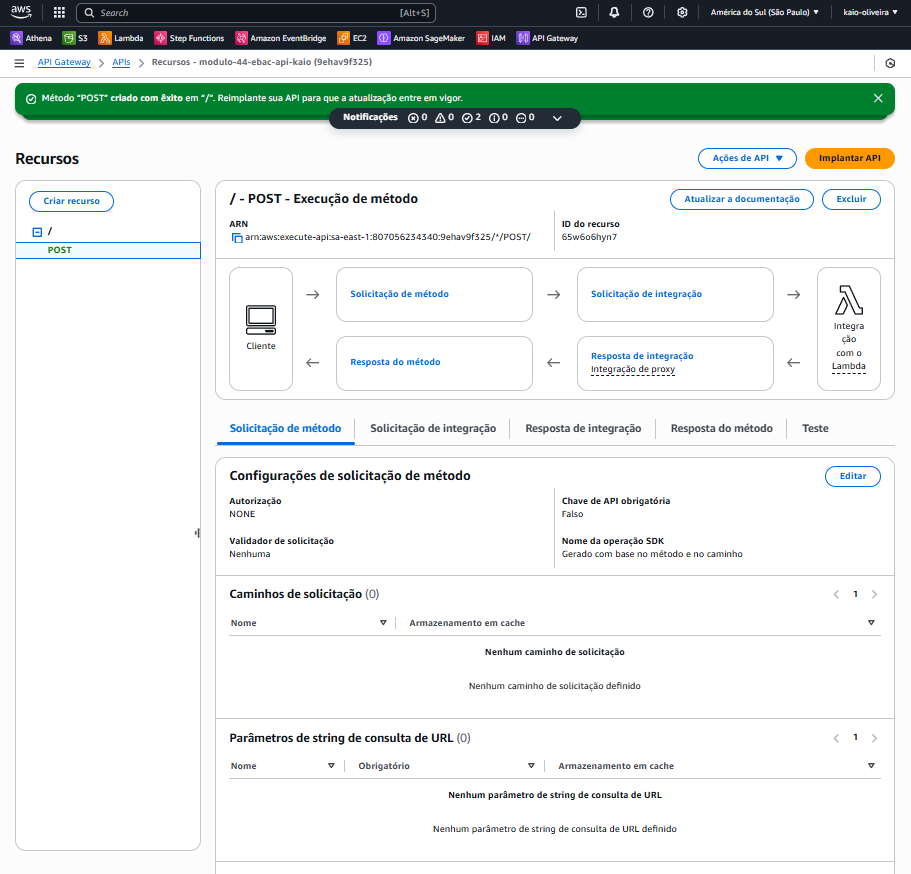

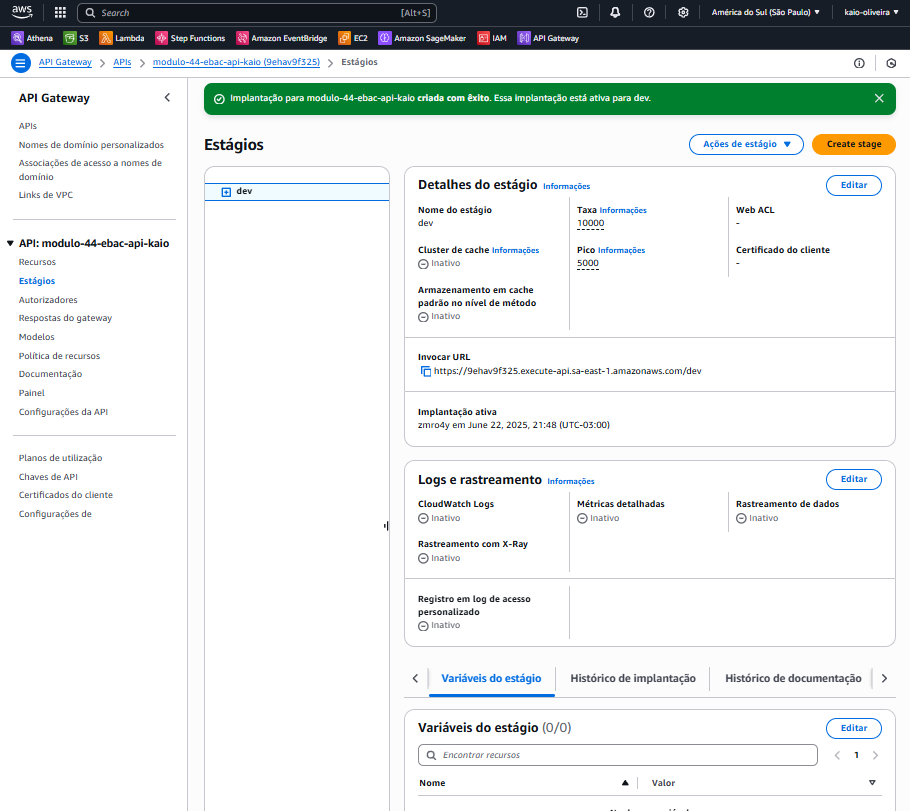

1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

A quinta etapa conecta o bot do Telegram ao seu endpoint HTTP: é preciso usar o método setWebhook da API de bots do Telegram, fornecendo a URL do API Gateway. Ao executar o comando via curl ou biblioteca específica, o Telegram começará a enviar todas as atualizações recebidas pelo bot diretamente para o seu Lambda, fechando o ciclo de ingestão automática.


> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

In [ ]:
from getpass import getpass
import requests

token = getpass()

··········


In [ ]:
aws_api_gateway_url = getpass()

··········


In [ ]:
base_url = f'https://api.telegram.org/bot{token}'
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}


In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://9ehav9f325.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "52.67.212.92"
  }
}


## 2\. ETL

Replique as atividades da aula 2.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

Com o pipeline de ingestão pronto, a sexta avaliação solicita a criação de um segundo bucket no S3, desta vez para armazenar os dados enriquecidos. Denominado com o sufixo -enriched, esse bucket será o destino das saídas processadas posteriormente, permitindo separar claramente o estado cru dos resultados transformados.

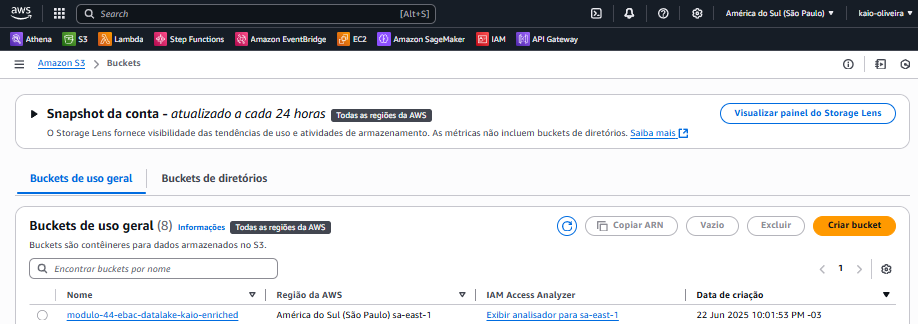

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

Na sétima etapa, você desenvolverá outra função Lambda cujo papel é processar apenas as mensagens JSON do dia anterior (D-1). Esse código deve listar os objetos do bucket -raw referentes à data apropriada, aplicar as regras de enriquecimento — como adicionar campos calculados, validar formatos ou agregar informações externas — e gravar o resultado no bucket -enriched.

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

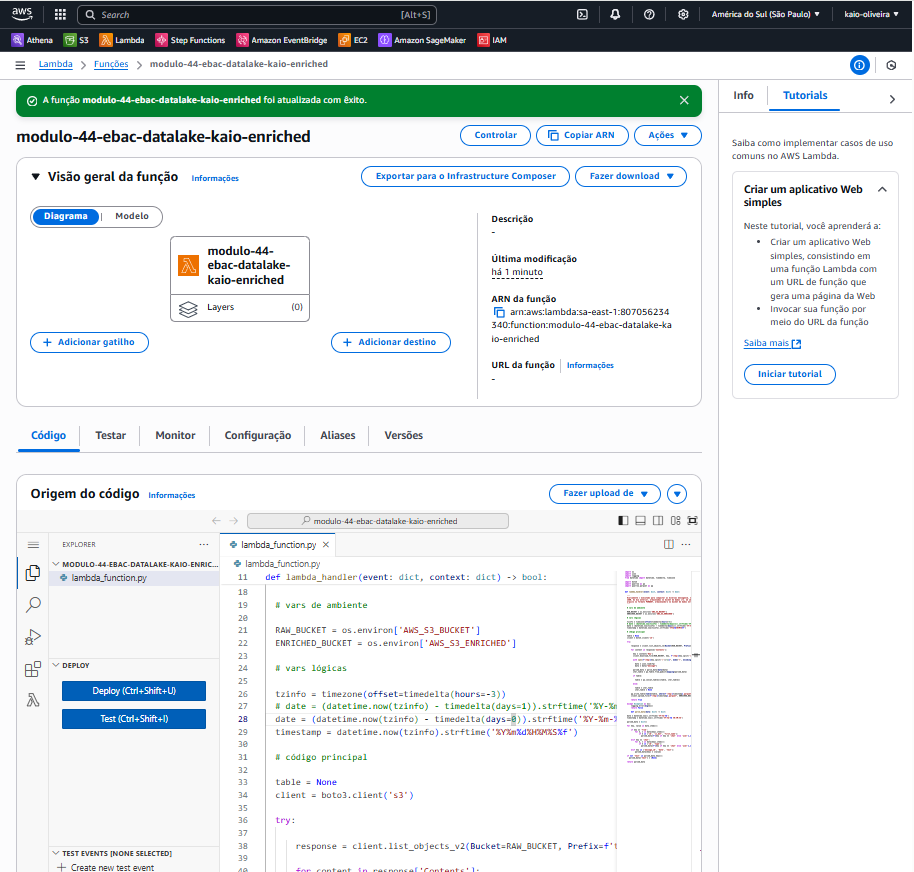

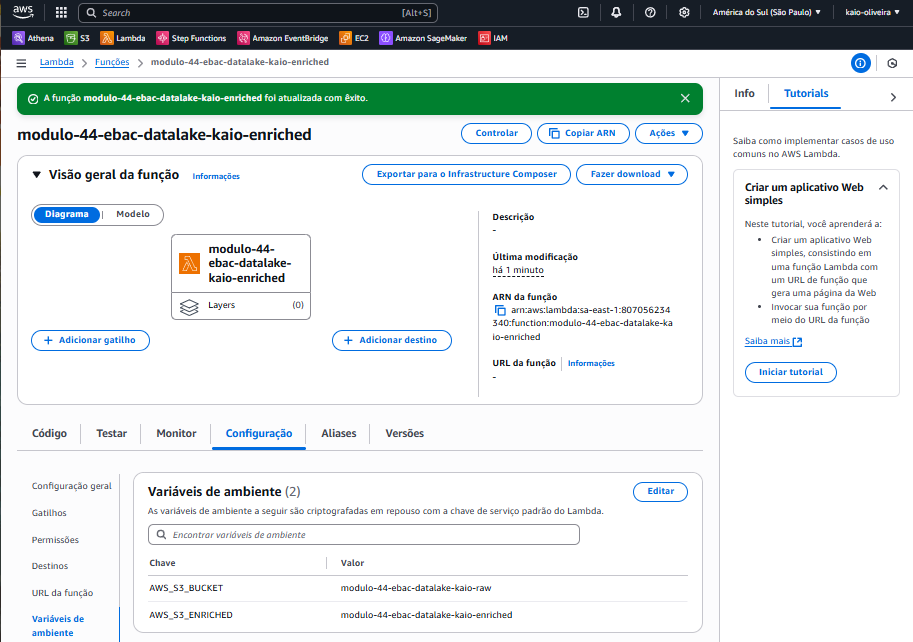

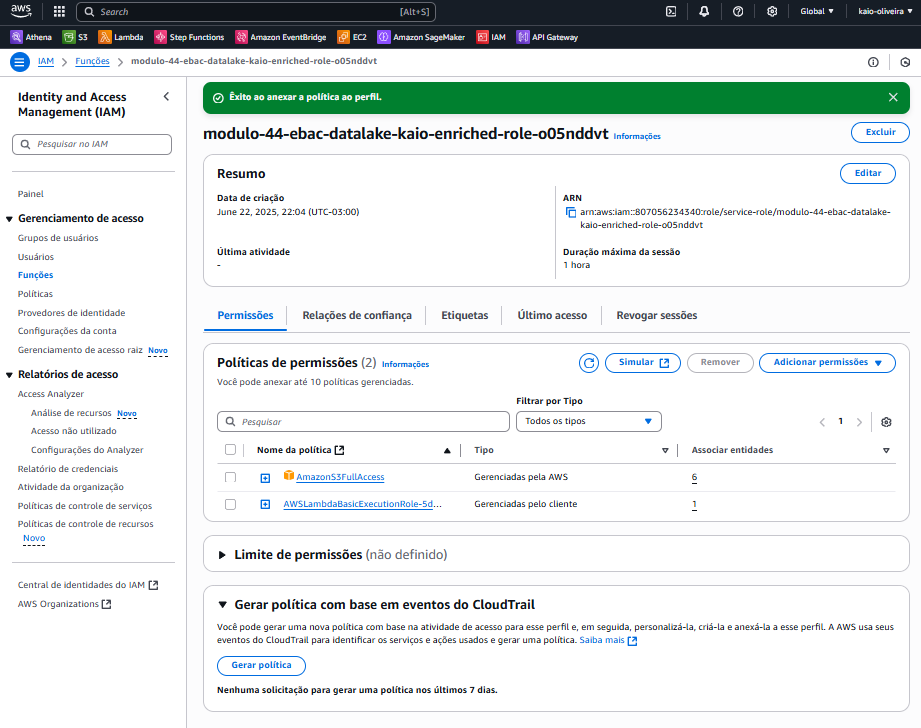

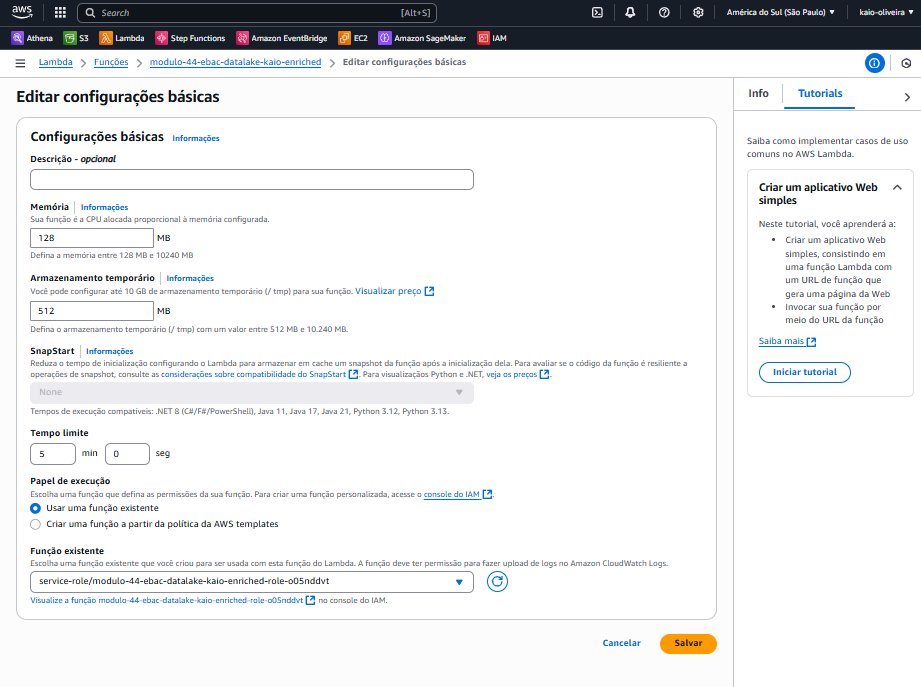

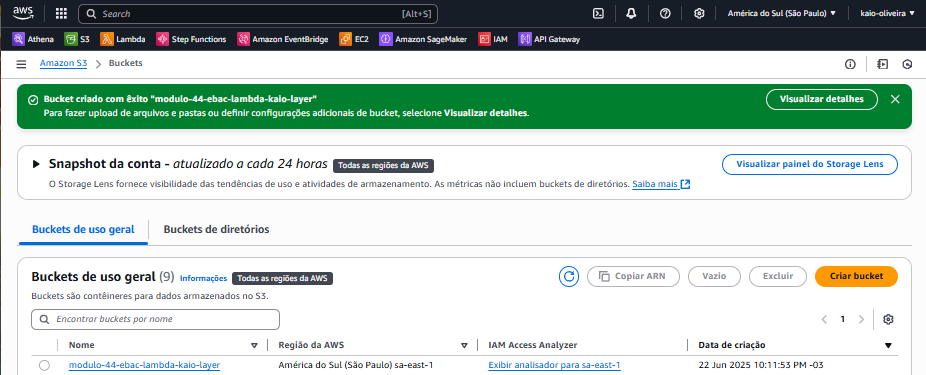

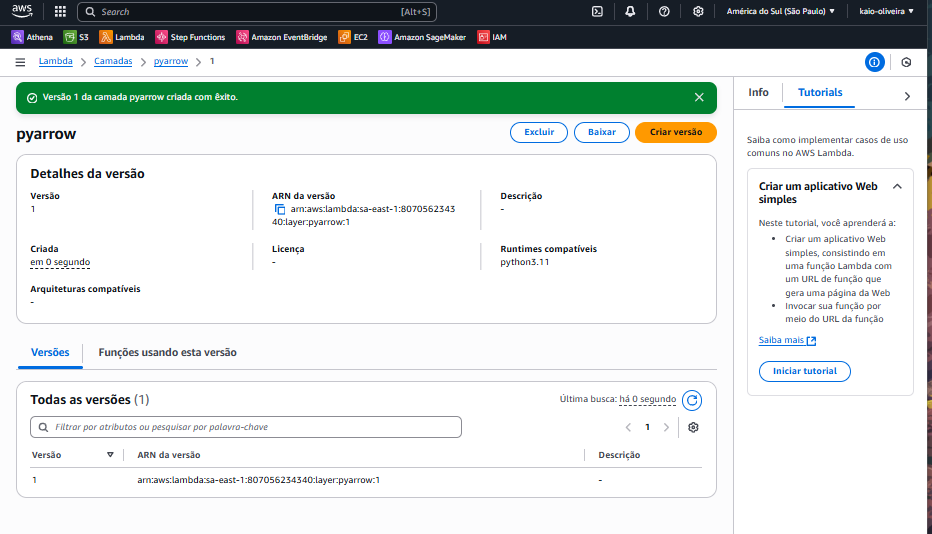

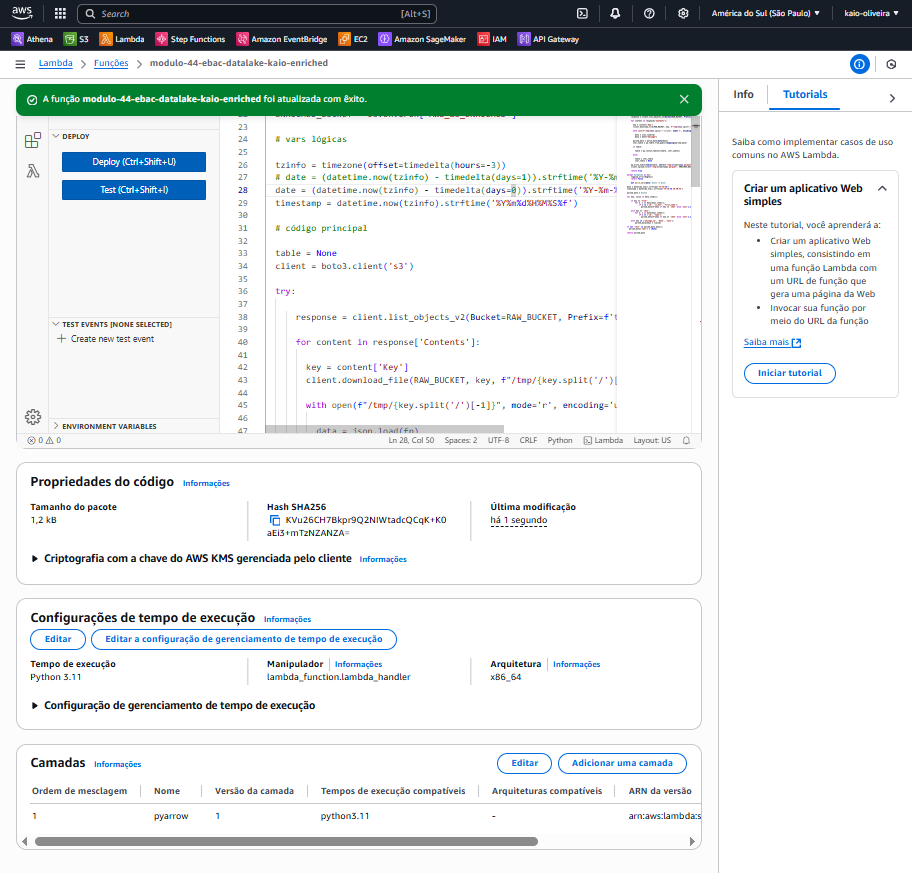

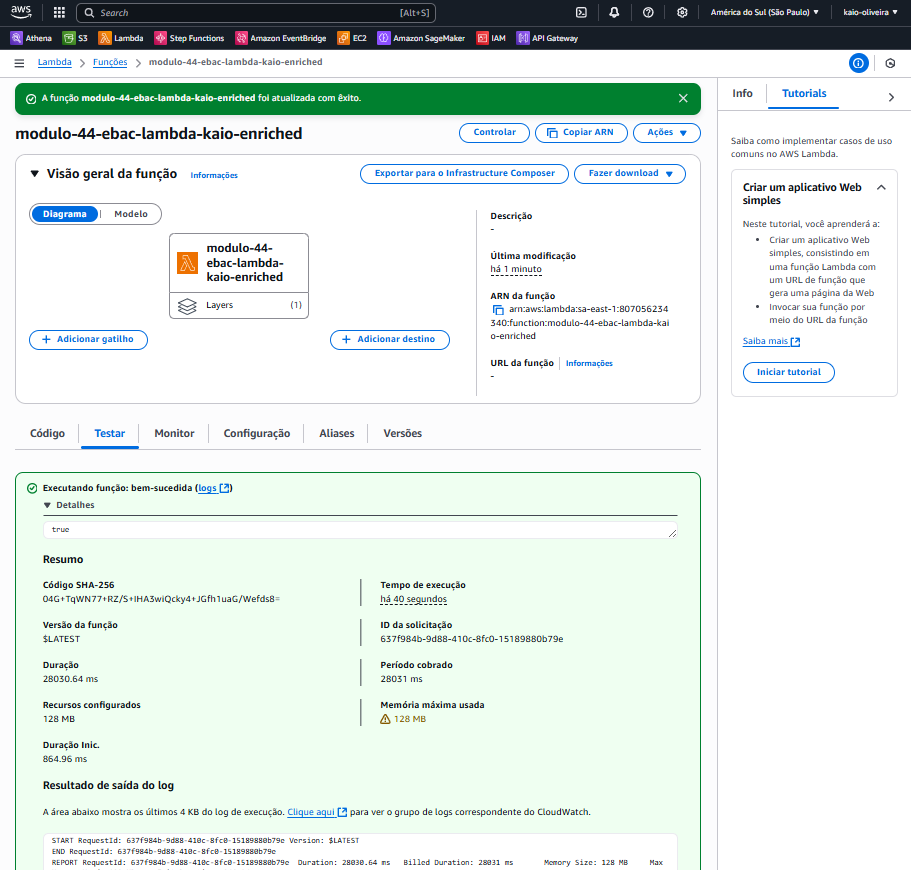

2.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

O agendamento dessa função de processamento automático é feito na oitava avaliação, criando uma regra no AWS EventBridge que dispare o Lambda todos os dias à meia-noite no horário de Brasília (GMT-3). Utilizando uma expressão cron como 0 3 * * ? * (que equivale a 00:00 em GMT-3), você garante que os dados de D-1 sejam processados logo após o final do dia, sem a necessidade de intervenção manual.

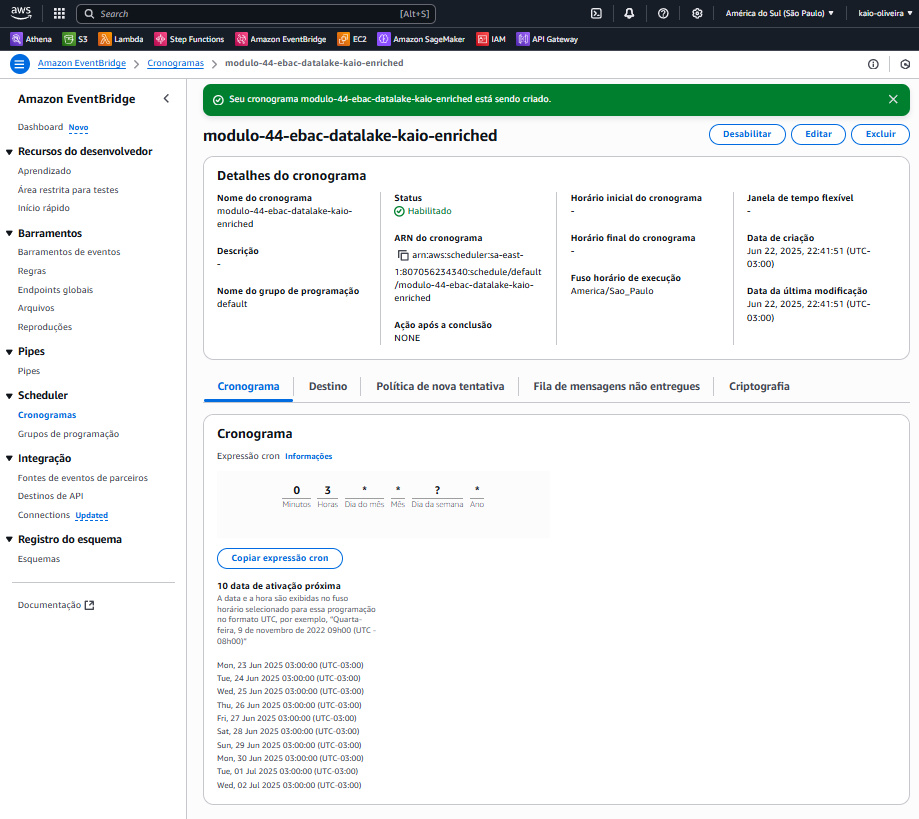

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

Para permitir a exploração analítica dos dados enriquecidos, a nona avaliação exige a criação de uma tabela externa no AWS Athena apontando para o bucket -enriched. Com um comando CREATE EXTERNAL TABLE, você define o schema dos arquivos (tipos de colunas, formatos, particionamento por data) e informa o local S3, estabelecendo o ambiente SQL sobre o seu data lake.

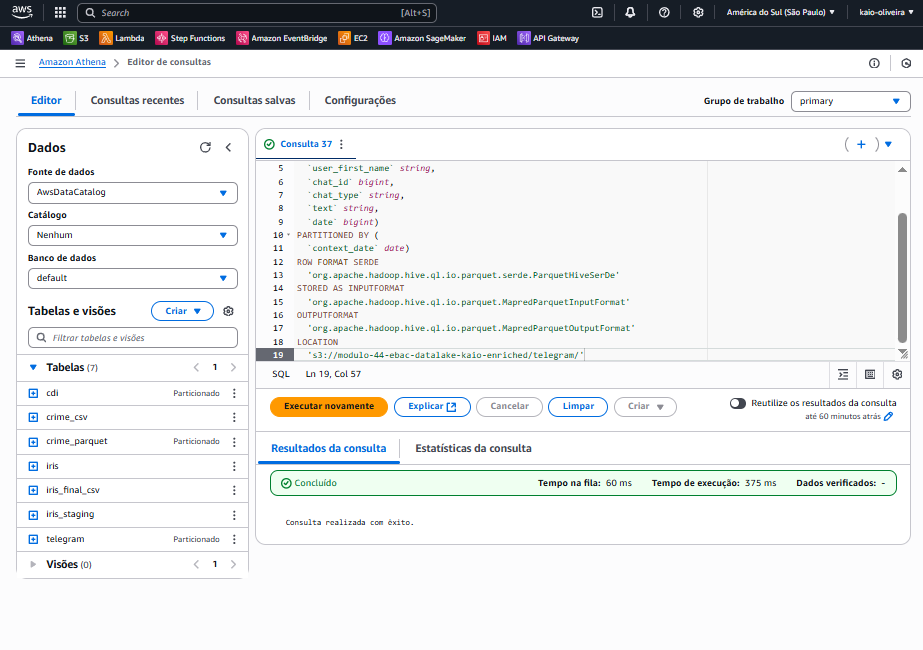

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

Após criar a tabela, é preciso executar o comando MSCK REPAIR TABLE (décima avaliação) para que o Athena descubra automaticamente todas as partições existentes no S3. Esse passo é essencial quando os arquivos estão organizados em pastas por data, pois registra cada partição no catálogo do Athena e permite consultas eficientes.

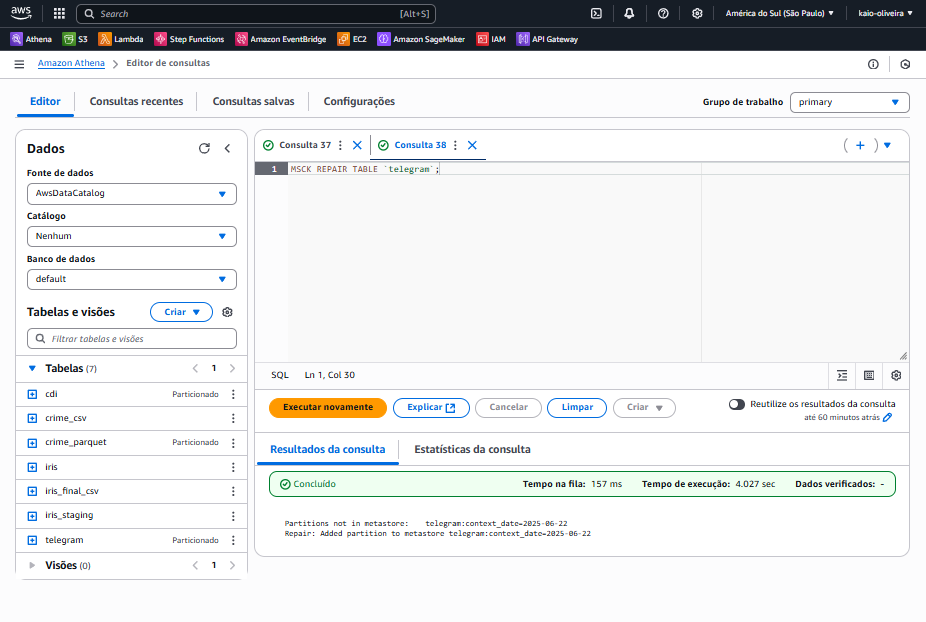

3.3. Execute as consultas SQL para explorar os dados.

Com tudo estruturado, a décima primeira avaliação pede que você escreva e execute consultas SQL no Athena para explorar métricas, contagens e analises dos dados processados. Use SELECT, WHERE, GROUP BY e outras cláusulas para extrair insights, avaliar a qualidade dos enriquecimentos e demonstrar domínio da ferramenta.


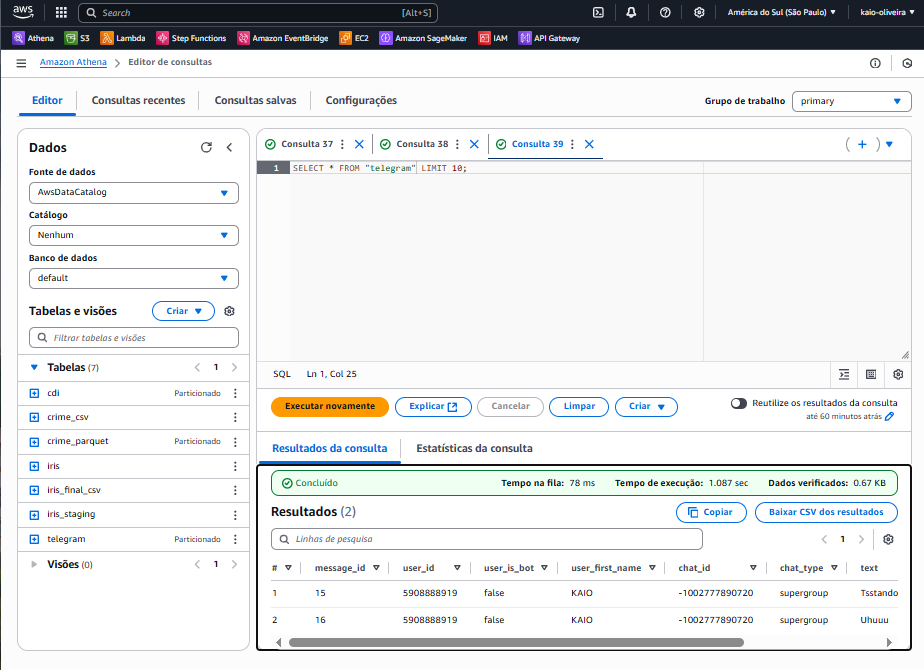

Quantidade de mensagens por dia:

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

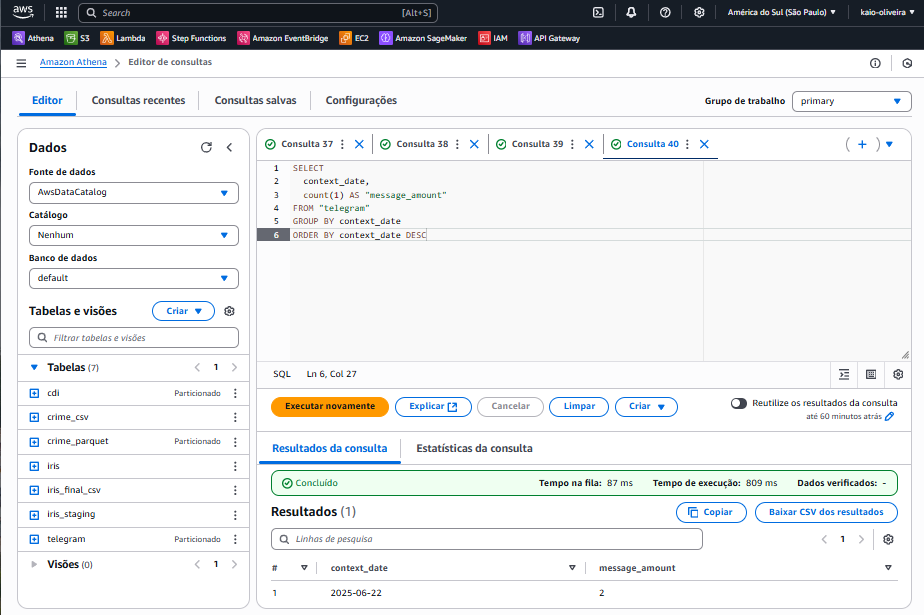

Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

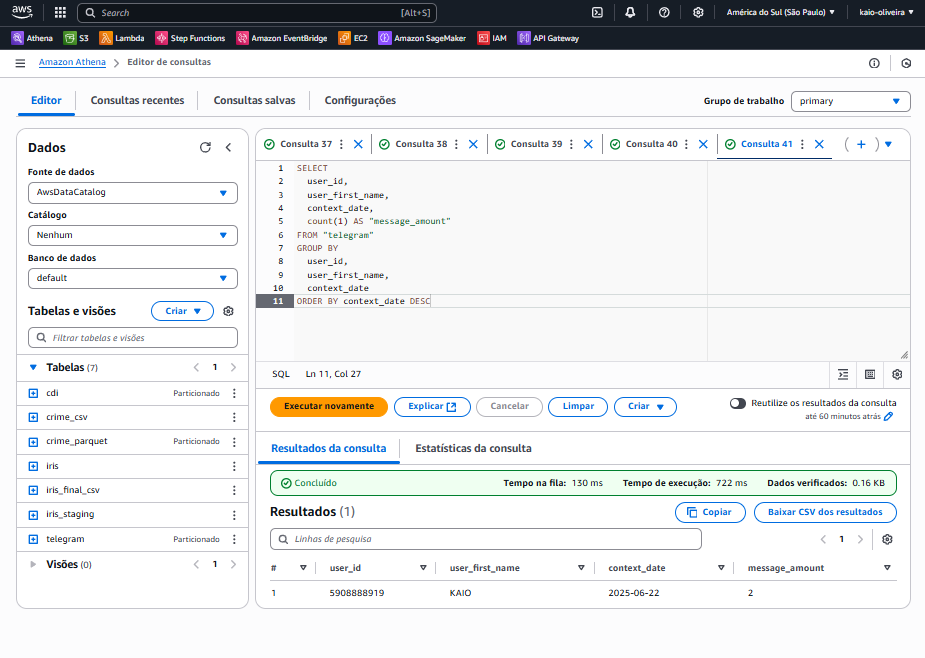

Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```


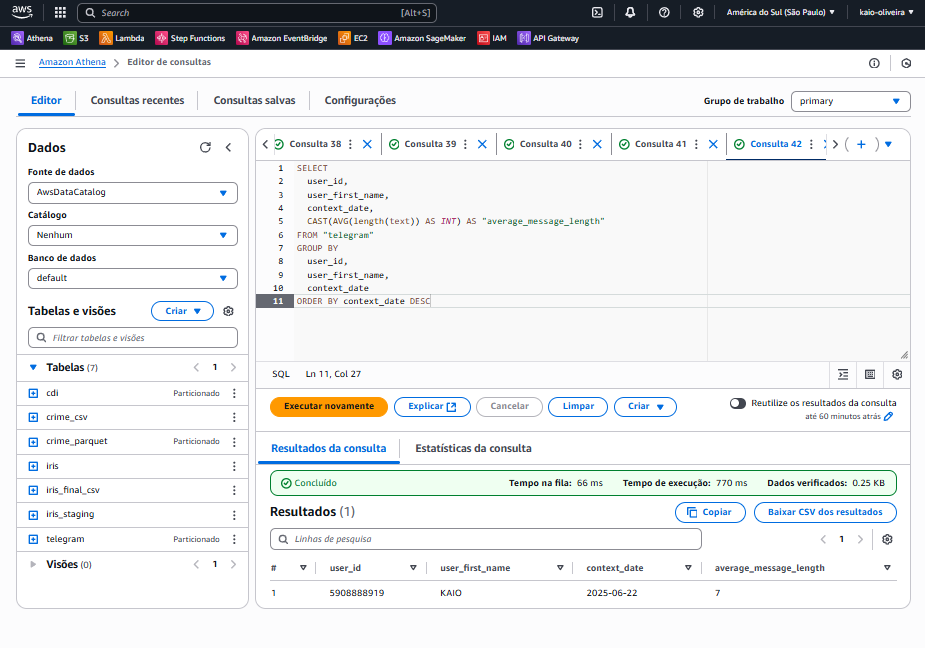

Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

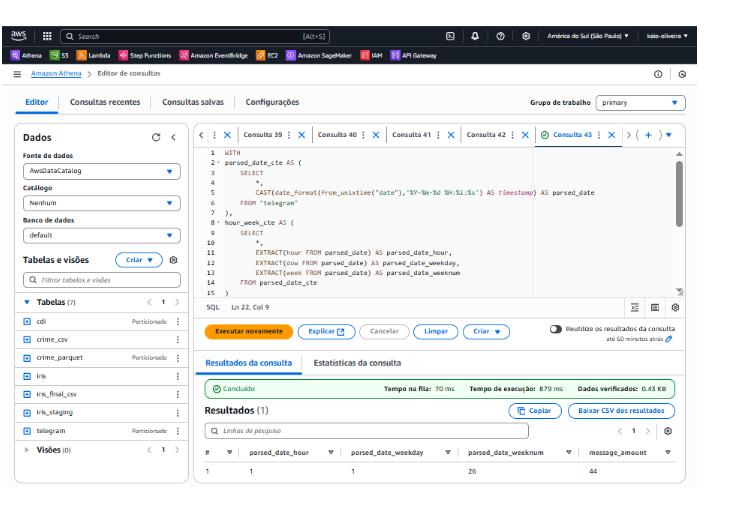

## 4\. Storytelling

Siga as dicas da aula 4 para expor o seu projeto.

Por fim, a décima segunda avaliação é aberta: ultrapassar as expectativas na apresentação do projeto. Aqui, serão considerados aspectos como clareza da documentação, qualidade dos slides ou relatório, uso de screenshots que comprovem cada passo, organização do código, comentários úteis e uma visão geral bem estruturada do pipeline implementado. Caprichar na apresentação faz toda a diferença na percepção do trabalho como um todo.

**Contexto do Projeto: De Chatbots a Big Data Analítico**
No mundo digital atual, os chatbots se tornaram ferramentas essenciais para a comunicação e interação. Plataformas como o Telegram geram um volume massivo de dados diariamente, dados estes que, em sua origem, são predominantemente transacionais. Eles registram eventos em tempo real, como o envio de uma mensagem, a entrada de um novo membro em um grupo, etc.

No entanto, para extrair valor estratégico desses dados – para entender padrões de uso, monitorar tópicos de conversa, ou até mesmo analisar o sentimento dos usuários – precisamos ir além do simples registro. Precisamos de um sistema analítico. A grande diferença aqui é que dados transacionais priorizam a escrita rápida e a consistência individual, enquanto dados analíticos focam na leitura eficiente, agregação e análise de grandes volumes históricos.

Nosso projeto surge dessa necessidade: criar uma infraestrutura que converta o fluxo contínuo de mensagens transacionais do Telegram em um formato otimizado para análise de Big Data, permitindo que extraíamos insights poderosos com eficiência e economia.

**Arquitetura do Pipeline: Do Telegram ao Insight**
Para atingir esse objetivo, concebemos e implementamos uma arquitetura de pipeline de dados que utiliza os serviços serverle

**1. Sistema Transacional: O Telegram e sua API de Bots**

No coração do nosso sistema transacional está o Telegram e sua poderosa API de Bots. É por meio dessa API que as mensagens e eventos do grupo são gerados.
Utilizamos um Webhook configurado no Telegram para enviar automaticamente cada nova mensagem ou evento para um endpoint na nuvem, garantindo uma captura de dados em tempo real.

**2. Sistema Analítico: As Três Etapas do Nosso Pipeline na AWS**

A jornada do dado transacional para o dado analítico se desdobra em três etapas principais:

**2.1. Ingestão:**

O endpoint que recebe os webhooks do Telegram é um AWS API Gateway.
Este API Gateway, por sua vez, invoca uma função AWS Lambda dedicada à ingestão.
Esta função Lambda, otimizada para ser "burra" (simples e rápida), recebe o payload JSON da mensagem do Telegram e o salva diretamente, sem grandes transformações, em um bucket S3.
Os dados brutos são armazenados no nosso RAW Data Lake (S3), particionados por data (telegram/context_date=YYYY-MM-DD/), o que facilita buscas futuras e gerenciamento.


**2.2. ETL (Extração, Transformação e Carga):**

Esta etapa é orquestrada por outra função AWS Lambda, programada para ser executada diariamente via Amazon EventBridge (CloudWatch Events).
Sua principal responsabilidade é ler os arquivos JSON brutos do dia anterior que estão no RAW_BUCKET.
Dentro da Lambda, os dados são transformados: campos específicos da mensagem (como message_id, date, text, informações do remetente (user_id, is_bot, first_name) e do chat (chat_id, type)) são extraídos e padronizados.
A grande otimização aqui é a conversão desses dados para o formato Apache Parquet. O Parquet é um formato de armazenamento orientado a colunas que, além de ser altamente compactável, permite que motores de consulta leiam apenas as colunas necessárias para uma análise, economizando recursos e tempo.
Após a transformação, os dados são carregados para um ENRICHED Data Lake (S3), também particionado por data, porém, agora em arquivos Parquet.

**2.3. Apresentação:**

* A camada de apresentação é habilitada pelo AWS Athena.
* O Athena é um serviço de consulta interativa que nos permite executar SQL diretamente sobre os dados Parquet particionados no S3, sem a necessidade de provisionar ou gerenciar servidores.
* Ele utiliza o AWS Glue Data Catalog para armazenar o esquema da nossa tabela, permitindo que a consultemos como uma tabela relacional comum.

**Análise Exploratória de Dados: A Eficiência em Números**

Neste projeto, o foco da análise exploratória de dados (AED) reside em demonstrar a eficiência do nosso pipeline, especialmente o impacto do formato Parquet e do particionamento nos custos e performance das consultas.

* Análise da Fonte (Dados Brutos da API):

* Ao obter dados diretamente da API de bots do Telegram (via getUpdates ou, em nosso caso, webhooks), recebemos um payload JSON completo que contém uma riqueza de informações sobre a mensagem, o remetente, o chat, e até mesmo metadados de mídia.
* Este JSON é "denso" e, embora detalhado, não é otimizado para consultas analíticas em grande escala, exigindo um "full scan" se armazenado diretamente para análise.

* Análise do Destino (Dados Otimizados para Apresentação):

* Na camada de apresentação, os dados estão no S3, no formato Parquet e particionados por context_date.
* Através do AWS Athena, podemos executar consultas SQL sobre esses dados. A grande sacada é a economia de dados escaneados. Por exemplo:
* Uma consulta simples sobre a tabela crime_csv (um conjunto de dados similar, em CSV) escaneou 47.34 MB, correspondendo a um "full scan" do arquivo.
* A mesma consulta, executada sobre a tabela crime_parquet (em formato Parquet e particionada), escaneou apenas 70.72 KB.
* Isso significa que a tabela com o dado particionado e orientado a colunas escaneou aproximadamente 685 vezes menos dados para a consulta SQL que seu par em CSV!

Esta redução drástica no volume de dados escaneados se traduz diretamente em menor custo de consulta (pois o Athena cobra por dados escaneados) e maior velocidade de execução das análises, validando a escolha do formato Parquet e da estratégia de particionamento.